# Photometry

Use this notebook in conjunction with PIRATE Week 5 Activity 5.5 - Open photometry results in Python, and with PIRATE Week 6 Activity 6.4 - Generate CMDs.

You will need to refer back to the `09-CreatingColourMagnitudeDiagrams.ipynb` notebook from PIRATE Week 3.

This notebook is in two parts:  
In the first section you will import results from an AstroImageJ measurements file and inspect the data.

In the second section you will use Eq 3.1b from PIRATE Week 3 to calculate magnitudes and then plot the Colour Magnitude Diagram (CMD).

## Part 0 - Loading the required packages

First, we will import all the packages that we will need.

In [1]:
import pandas as pd # Pandas is a common package for handling data as tables know as DataFrames
import re           # for Regular expressions

In [2]:
strFileName = "MeasurementsM36.xls" # Save the filename as a string. Ensure you include the file extension (.xls)

In [3]:
ClusterData = pd.read_csv(strFileName, sep = "\t") # Read data from the file into a Pandas DataFrame

In [4]:
display(ClusterData)

,,Label,J.D.-2400000,JD_UTC,rel_flux_C1,rel_flux_T2,rel_flux_T3,rel_flux_T4,rel_flux_T5,rel_flux_T6,...,rel_flux_err_T439,rel_flux_err_T440,rel_flux_err_T441,rel_flux_err_T442,rel_flux_err_T443,rel_flux_err_T444,rel_flux_err_T445,rel_flux_err_T446,rel_flux_err_T447,rel_flux_err_T448
0,1,PIRATE_103196_OSL_00_add6_M36_00_V32_00_2024_1...,60626.527991,2.460627e+06,0.0,1.124030,1.322628,0.632507,0.056162,0.006331,...,0.000075,0.000073,0.000092,0.000076,0.000117,0.000066,0.000104,0.000064,0.000063,0.000063
1,2,PIRATE_103197_OSL_00_add6_M36_00_B32_00_2024_1...,60626.528567,2.460627e+06,0.0,1.155432,1.367942,0.644801,0.045906,0.003960,...,0.000069,0.000066,0.000076,0.000069,0.000114,0.000059,0.000100,0.000061,0.000057,0.000049


One task is to remove all of the data that we do not need. The `read_csv()` function has very useful tool called `usecols` for this purpose. `usecols`is an optional input that can take either a list of columns to include, or a user-defined function. When you pass a user-defined function to `usecols`, it evaluates each column name and includes the column if the function returns True. This allows you to filter columns dynamically based on a specific criteria.

Looking at the data, we can see that the columns we are interested in begin 'rel_flux_T' followed by a number, whereas the columns we do not want have other titles, such as beginning 'J.D.', or they are error values for the flux ('rel_flux_err_T'). So we will write a function that will check if the column name matches certain criteria. If either the first 10 characters of the column name match the string `"rel_flux_T"` or if the column name is `"Label"` this function will return `True`, or else it will return `False`.

In [5]:
def isValidCol(colName):                                       # Sets the function name and the input name used within
    if (colName[0:10] == 'rel_flux_T' or colName == 'Label'):  # If statement with two true conditions
        return True                                            # Returns True if either of the above conditions met
    else:
        return False                                           # Returns False if neither condition is met

Now by passing this user defined function for the `usecols` option input, we can rerun `read_csv()` and only retain the columns we want.

In [6]:
ClusterData = pd.read_csv(strFileName, sep = '\t', usecols = isValidCol) # Rerun read_csv() only keeping desired columns

display(ClusterData) # Display the DataFrame to check it has only included the requested columns

,Label,rel_flux_T2,rel_flux_T3,rel_flux_T4,rel_flux_T5,rel_flux_T6,rel_flux_T7,rel_flux_T8,rel_flux_T9,rel_flux_T10,...,rel_flux_T439,rel_flux_T440,rel_flux_T441,rel_flux_T442,rel_flux_T443,rel_flux_T444,rel_flux_T445,rel_flux_T446,rel_flux_T447,rel_flux_T448
0,PIRATE_103196_OSL_00_add6_M36_00_V32_00_2024_1...,1.124030,1.322628,0.632507,0.056162,0.006331,0.003090,0.105049,0.007061,0.019807,...,0.007293,0.006786,0.012536,0.007627,0.021064,0.005021,0.016340,0.004606,0.004363,0.004682
1,PIRATE_103197_OSL_00_add6_M36_00_B32_00_2024_1...,1.155432,1.367942,0.644801,0.045906,0.003960,0.001708,0.098412,0.004427,0.012834,...,0.004452,0.004089,0.006197,0.004815,0.016563,0.002754,0.012125,0.003078,0.002529,0.001425


Next we want to change the labels for the rows to ensure they are labelled as either `B` or `V`.

To rename the rows correctly we first want to search through the column called `Label` and identify which column contains the B band flux values.


### Using list comprehension to search for regular expressions

This notebook also uses _regular expressions_ to identify the rows in the data file that contain values from the B and V filters.  Refer to the `06-UsingRegex.ipynb` notebook from the Full Moon Skills weeks for information on using Regular expressions.

First, we define what we are looking for. We are looking for strings that match the following regular expression:

In [7]:
strFilter = r'.*_([BV]).*' # Define a regular expression that will match any strings that contain _B or _V

This looks complex but all it actually says is that it will match any string that contains either `_B` or `_V`. 

Next, we need to replace the row labels with either B or V depending on the value within the column `'Label'`. This is where we will employ _**list comprehension**_ to generate a new list of 2 strings (one for each row) and apply this to `ClusterData['Label']`

As we did in the list comprehension example, we will run a function on each of the elements in the list `ClusterData['Label']` but this time the function will overwrite the existing values in `ClusterData['Label']`

In [8]:
ClusterData['Label'] = [re.search(strFilter, x).group(1) for x in ClusterData['Label']] # Searching for B or V in label

If we look at the line `ClusterData['Label'] = [re.search(strFilter, x).group(1) for x in ClusterData['Label']]` in detail, we see it is of the same structure as the example we had before (`double_numbers = [x*2 for x in numbers]`), simply replacing the list `numbers` with our column `ClusterData['Label']`. The only difference is the function we are running. Instead of simply multiplying `x` by 2, we are doing something more complex.

The function `re.search(strFilter, x).group(1)` is searching `x` and seeing if it matches the regular expression we specified in `strFilter`. This is what the `re.search(strFilter, x)` part does. Remember that this regular expression will match any string with either `_B` or `_V`. Finally, the `.group(1)` method of the `re.search()` function ensures that the returned matching part of the regular expression is the element from the character class specified in the regular expression, e.g. either `B` or `V`.

As with any change to the data, we can check it by displaying the DataFrame again.


In [9]:
display(ClusterData) # Display the DataFrame to check the change has occurred.

,Label,rel_flux_T2,rel_flux_T3,rel_flux_T4,rel_flux_T5,rel_flux_T6,rel_flux_T7,rel_flux_T8,rel_flux_T9,rel_flux_T10,...,rel_flux_T439,rel_flux_T440,rel_flux_T441,rel_flux_T442,rel_flux_T443,rel_flux_T444,rel_flux_T445,rel_flux_T446,rel_flux_T447,rel_flux_T448
0,V,1.124030,1.322628,0.632507,0.056162,0.006331,0.003090,0.105049,0.007061,0.019807,...,0.007293,0.006786,0.012536,0.007627,0.021064,0.005021,0.016340,0.004606,0.004363,0.004682
1,B,1.155432,1.367942,0.644801,0.045906,0.003960,0.001708,0.098412,0.004427,0.012834,...,0.004452,0.004089,0.006197,0.004815,0.016563,0.002754,0.012125,0.003078,0.002529,0.001425


As expected, we now have each row being denoted as either `B` or `V`. 

Next, we are going to set this column to be our index. This is because when we transpose our DataFrame, the indexes will become the column names. We can use the `.set_index()` method on the DataFrame to modify the object. We specify that the column we wish to be used as the index is called `'Label'` and we include the optional input `inplace=True` to change the DataFrame in place (i.e. we do not need to save the DataFrame again to overwrite itself).


In [10]:
ClusterData.set_index('Label', inplace = True) # Set the column called 'Label' to be the index for the DataFrame.

Next, we are going to transpose our data to switch the rows for columns. Luckily, there is a built-in method for this process in Pandas. We simply need to overwrite our existing DataFrame with the transposed version. We will then immediately display the DataFrame to demonstrate it has happened as we expect.

**Be careful! As we are overwriting our original DataFrame, every time we run this we will transpose the DataFrame.**


In [11]:
ClusterData = ClusterData.transpose()  # Transpose 

display(ClusterData)

Label,V,B
rel_flux_T2,1.124030,1.155432
rel_flux_T3,1.322628,1.367942
rel_flux_T4,0.632507,0.644801
rel_flux_T5,0.056162,0.045906
rel_flux_T6,0.006331,0.003960
...,...,...
rel_flux_T444,0.005021,0.002754
rel_flux_T445,0.016340,0.012125
rel_flux_T446,0.004606,0.003078
rel_flux_T447,0.004363,0.002529


For instance: `ClusterData['FluxRatio'] = ClusterData['B']/ClusterData['V']`
would create a new column labelled `'FluxRatio'`

Try this now, by running the next cell:

In [12]:
ClusterData['FluxRatio'] = ClusterData['B']/ClusterData['V'] # Creates a new column called FluxRatio

display(ClusterData)

Label,V,B,FluxRatio
rel_flux_T2,1.124030,1.155432,1.027937
rel_flux_T3,1.322628,1.367942,1.034261
rel_flux_T4,0.632507,0.644801,1.019437
rel_flux_T5,0.056162,0.045906,0.817385
rel_flux_T6,0.006331,0.003960,0.625494
...,...,...,...
rel_flux_T444,0.005021,0.002754,0.548496
rel_flux_T445,0.016340,0.012125,0.742044
rel_flux_T446,0.004606,0.003078,0.668259
rel_flux_T447,0.004363,0.002529,0.579647


This will be important when you come to work on your own data from your PIRATE observations. For these, you will need to calculate apparent B and apparent V magnitudes, as well as the B-V colour.

## Part 2 - Calculate magnitudes and plot CMD

Now that you have completed your observations, your next task for Activity 6.4 is to create CMDs based on stars you have observed with PIRATE (or COAST).

You then need to calculate the **apparent magnitudes** and the **B-V** colour before creating a CMD.

First, import a few additional packages.


In [13]:
import numpy as np               # Numpy has essential tools for manipulating lists of data
import matplotlib.pyplot as plt  # Matplotlib is the tool for plotting data

Next, we are going to set the size of the plots we produce by replacing the default `rcParam['figure.figsize']` values. If you have not encountered this yet, we will be going through it for the `04-UsingMatplotlib.ipynb` notebook during the Full Moon Skills Week. Check there for a detailed explanation.


In [14]:
plt.rcParams['figure.figsize'] = [12, 8] # Set figure.figsize to be 12 inches wide and 8 inches high.

The values in the AstroImageJ results file are _relative fluxes_ - in other words, each value is the brightness of the target star (in the B or V band) divided by the brightness of the reference. To produce the Colour Magnitude Diagram, these need to be converted to apparent magnitudes. To do this, remind yourself of Eq 3.1b from PIRATE Week 3:

\begin{equation}
m_1 - m_2 = -2.5 \log_{10} \left(\dfrac{F_1}{F_2}\right)  \tag{3.1b}
\end{equation}

Because AstroImageJ results file are _relative fluxes_ we can say that the values in the `ClusterData['B']` and `ClusterData['V']` columns each equate to $\dfrac{F_1}{F_2}$ for their respective filter bands.

The final piece of information we need is the apparent magnitude in the B and V bands of the reference star (See Activity 3.6 'Select a reference star'). This is the catalogue magnitude. Enter these in the code cell below:

In [15]:
REF_B_MAG =  9.154                            # <<<< Enter the apparent B magnitude of the reference star
REF_V_MAG =  9.076                            # <<<< Enter the apparent V magnitude of the reference star

With the magnitude of the reference star saved as a variable, we can now rearrange the equation Eq 3.1b from PIRATE Week 3. We want to make the apparent magnitude of the target star the subject, as shown:

\begin{equation}
m_1 = -2.5 \log_{10} \left(\dfrac{F_1}{F_2}\right) + m_2
\end{equation}

You now need to employ this equation to add two new columns in to the ClusterData. Look again at the final code example of Part 1 of this notebook where we showed:

`ClusterData['FluxRatio'] = ClusterData['B']/ClusterData['V']`

You should now do something similar below to complete the lines of code to create the columns `ClusterData['Bmag']` and `ClusterData['Vmag']`. 

You can use `np.log10(...)` to calculate logs to base 10.

When these have been created you can make another new column, `ClusterData['B_V']` for the colour B-V.


In [16]:
ClusterData['Bmag'] = ClusterData['Bmag'] = -2.5 * np.log10(ClusterData['B']) + REF_B_MAG       # <<<< Calculate the apparent B magnitude using the rearranged equation 3.1b

In [17]:
ClusterData['Vmag'] = ClusterData['Vmag'] = -2.5 * np.log10(ClusterData['V']) + REF_V_MAG        # <<<< Calculate the apparent V magnitude using the rearranged equation 3.1b

In [18]:
ClusterData['B_V']  = ClusterData['B_V'] = ClusterData['Bmag'] - ClusterData['Vmag']             # <<<< Calculate the colour index B-V by subtracting Vmag from Bmag

So in the first two above we calculate Bmag and Vmag:
Hence for each row in the DataFrame, we use the np.log10() function to calculate the base-10 logarithm of the "relative flux" in the B and V bands, respectively.
We then multiply this value by -2.5 and add the corresponding reference magnitude (either REF_B_MAG or REF_V_MAG) to obtain the "apparent magnitude".

Then we calculate the B_V:
The B_V color index is simply the difference between the B and V magnitudes, calculated by subtracting Vmag from Bmag

Display the DataFrame again to ensure these calculations have resulted in the creation of these new columns.

In [19]:
display(ClusterData.head(5)) # Display the top 5 lines to check the new columns have been calculated correctly

Label,V,B,FluxRatio,Bmag,Vmag,B_V
rel_flux_T2,1.124030,1.155432,1.027937,8.997139,8.949055,0.048084
rel_flux_T3,1.322628,1.367942,1.034261,8.813831,8.772406,0.041425
rel_flux_T4,0.632507,0.644801,1.019437,9.630436,9.573337,0.057099
rel_flux_T5,0.056162,0.045906,0.817385,12.499326,12.202394,0.296933
rel_flux_T6,0.006331,0.003960,0.625494,15.159762,14.572319,0.587443


This is an excellent opportunity to check your calculations. Did the values for `Bmag` and `Vmag` calculate correctly? You could calculate a few manually to check, or you could conduct a 'sense check' i.e. do the outputs make sense? Are they within the range of values you expect? What is the apparent magnitude of the reference star? Would you expect your calculated values to be vastly different? You would not expect minus numbers, nor very small single digit numbers, nor large 3-digit numbers.

Carry out the same sense check for the `B-V` colour. Based on the values of `Bmag` and `Vmag` shown, has `B-V` been calculated correctly?

Finally, you should now create a CMD diagram based on this data. See the `09-Creating_Colour_Magnitude_Diagrams.ipynb` notebook to guide you in how to do this. Either copy in the code for a CMD or write it yourself from scratch.


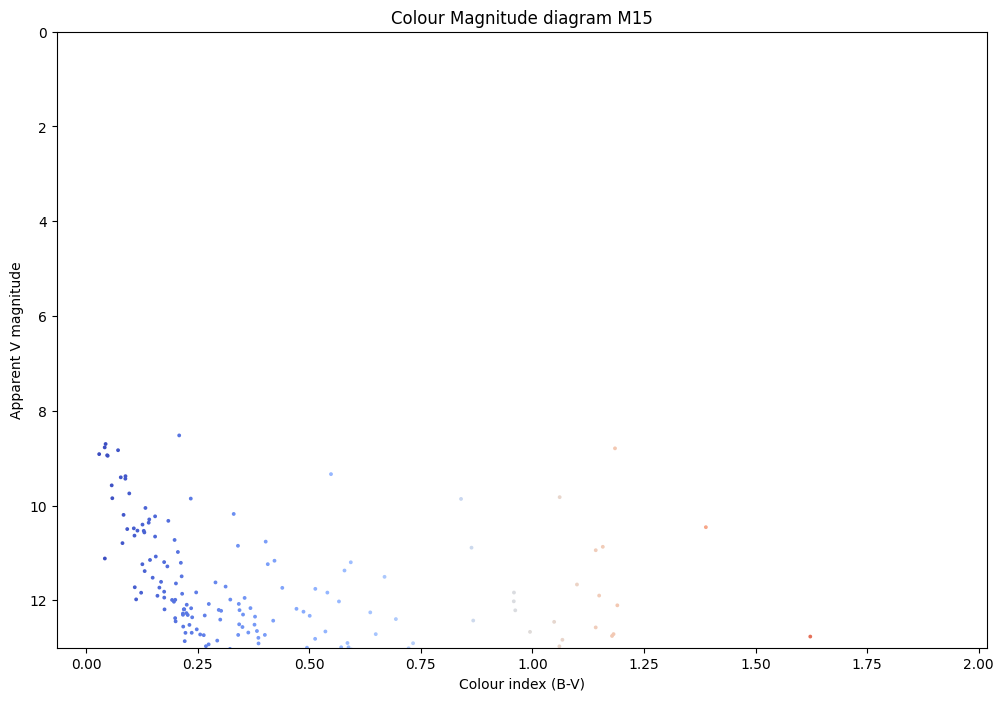

In [20]:
# Enter your code for your CMD plot here.
import matplotlib.pyplot as plt

# Plot the CMD
plt.scatter(ClusterData["B_V"], ClusterData["Vmag"], c=ClusterData["B_V"], cmap="coolwarm", s=3)

# Set y axis limits (adjust as needed based on your data)
plt.ylim((13, 0))  # Invert y-axis

# Set plot title, labels, and show the plot
plt.title('Colour Magnitude diagram M15')
plt.xlabel('Colour index (B-V)')
plt.ylabel('Apparent V magnitude')
plt.show()




Once you have completed your program and checked the calculations, repeat the processing for each of the clusters that you have imaged and generate a CMD for each.

You can either keep the notebook in its current form, running each of the cells in turn, or combine the steps to give a complete program in one cell.

Do not forget the final guidance within the **Creating Colour Magnitude Diagrams** notebook and think about how to enhance your CMD with annotations that will help the reader interpret what they see.


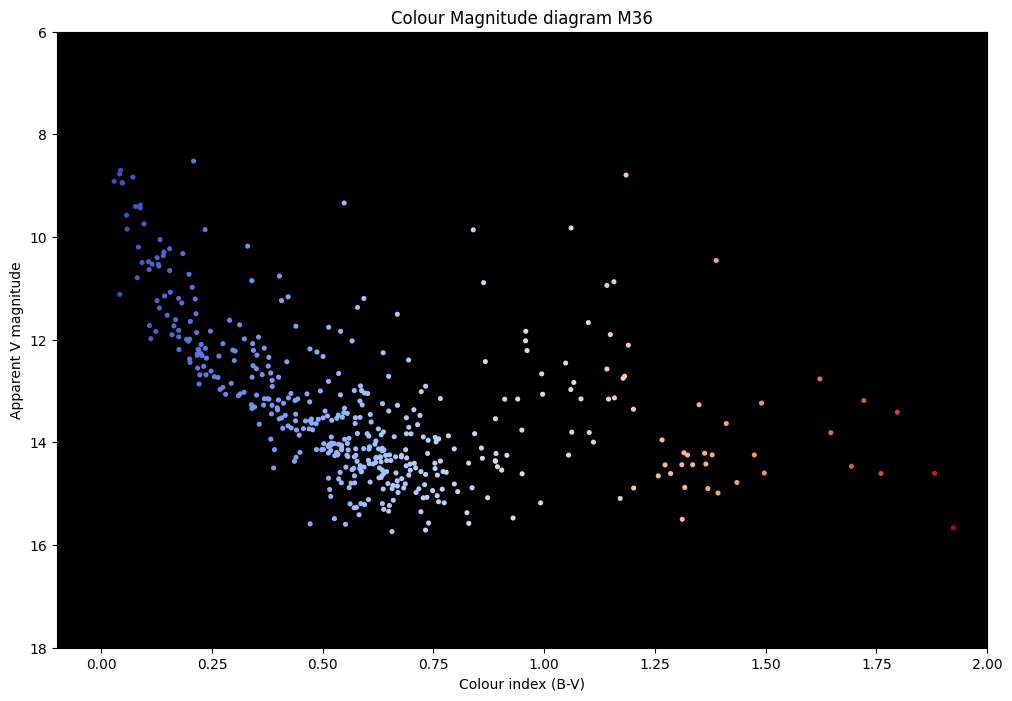

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Plot the CMD
plt.scatter(ClusterData["B_V"], ClusterData["Vmag"], c=ClusterData["B_V"], cmap="coolwarm", s=7)  # Increase marker size to 10

# Here we set y axis limits to show data below 8 for apparent V magnitude
plt.ylim((18, 6))  # Invert y-axis to match convention

# Here we adjust x axis limits to show a wider range of B-V color index values
plt.xlim((-0.1, 2.0))  # Adjust as needed

# then we set plot title, labels, and show the plot
plt.title('Colour Magnitude diagram M36')
plt.xlabel('Colour index (B-V)')
plt.ylabel('Apparent V magnitude')

# and change the background color to black
fig = plt.gcf()
ax = plt.gca()
ax.set_facecolor('black')

plt.show()

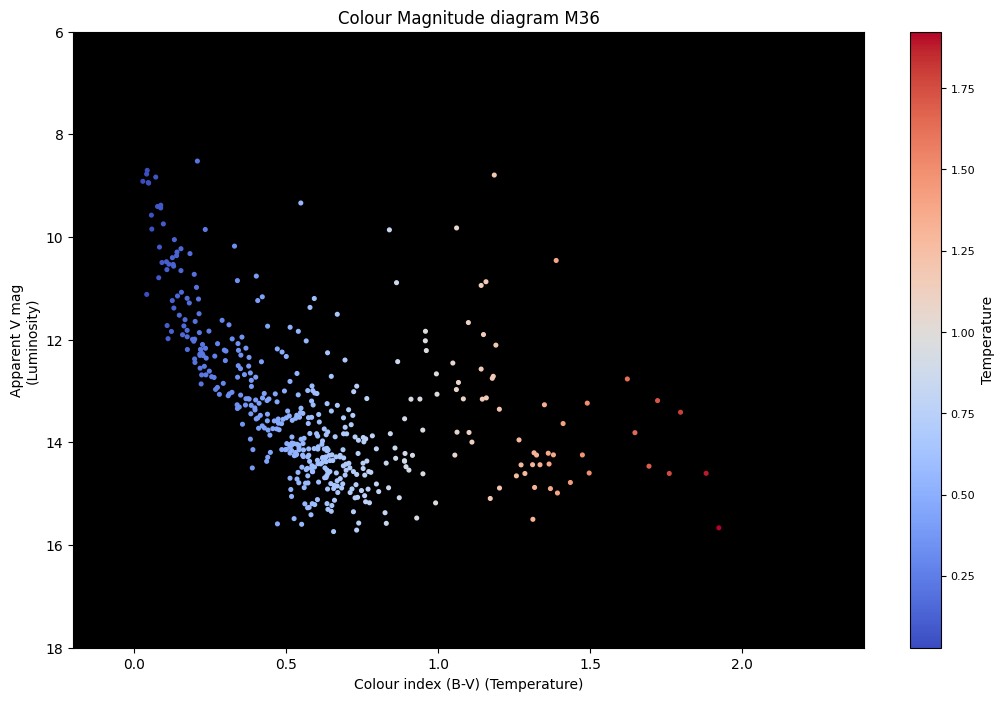

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colorbar import Colorbar

# Plot the CMD
plt.scatter(ClusterData["B_V"], ClusterData["Vmag"], c=ClusterData["B_V"], cmap="coolwarm", s=7)  # Increase marker size to 7

# Set y axis limits to show data below 8 for apparent V magnitude
plt.ylim((18, 6))  # Invert y-axis to match convention

# Set x axis limits to show a wider range of B-V color index values
plt.xlim((-0.2, 2.4))  # Adjust as needed

# Set plot title, labels 
plt.title('Colour Magnitude diagram M36')
plt.xlabel('Colour index (B-V) (Temperature)')  # Add temperature text to label
plt.ylabel('Apparent V mag\n(Luminosity)') #added an extra label

# Create a colorbar on the right side
cbar = plt.colorbar(fraction=0.1, orientation='vertical', label='Temperature', aspect=20)  # Adjust aspect ratio
cbar.ax.tick_params(labelsize=8)  # Adjust tick label size

# Change the background color to black
fig = plt.gcf()
ax = plt.gca()
ax.set_facecolor('black')

plt.show()

In [23]:
import numpy as np

# Define constants
M_v = 0.70  # Absolute V magnitude of an A0 main sequence star
AV_factor = 3  # Conversion factor for A_v from E(B-V)
E_BV = 0.22  # E(B-V) value for M36
pc = 3.26  # 1 parsec in light-years

# Calculate A_v (interstellar extinction)
A_v = AV_factor * E_BV

# Create a new column for distance (d/pc)
ClusterData['distance_pc'] = 10**((ClusterData['Vmag'] - M_v + 5 - A_v) / 5)

# Convert distance from parsec to light-years
ClusterData['distance_ly'] = ClusterData['distance_pc'] * pc

print("Distance (pc) and Distance (Light-Years) calculated and added to the DataFrame")
display(ClusterData.head())  # Display the top few rows to check the new columns

Distance (pc) and Distance (Light-Years) calculated and added to the DataFrame


Label,V,B,FluxRatio,Bmag,Vmag,B_V,distance_pc,distance_ly
rel_flux_T2,1.124030,1.155432,1.027937,8.997139,8.949055,0.048084,329.466338,1074.060262
rel_flux_T3,1.322628,1.367942,1.034261,8.813831,8.772406,0.041425,303.725422,990.144875
rel_flux_T4,0.632507,0.644801,1.019437,9.630436,9.573337,0.057099,439.205057,1431.808486
rel_flux_T5,0.056162,0.045906,0.817385,12.499326,12.202394,0.296933,1473.936309,4805.032367
rel_flux_T6,0.006331,0.003960,0.625494,15.159762,14.572319,0.587443,4389.993157,14311.377691


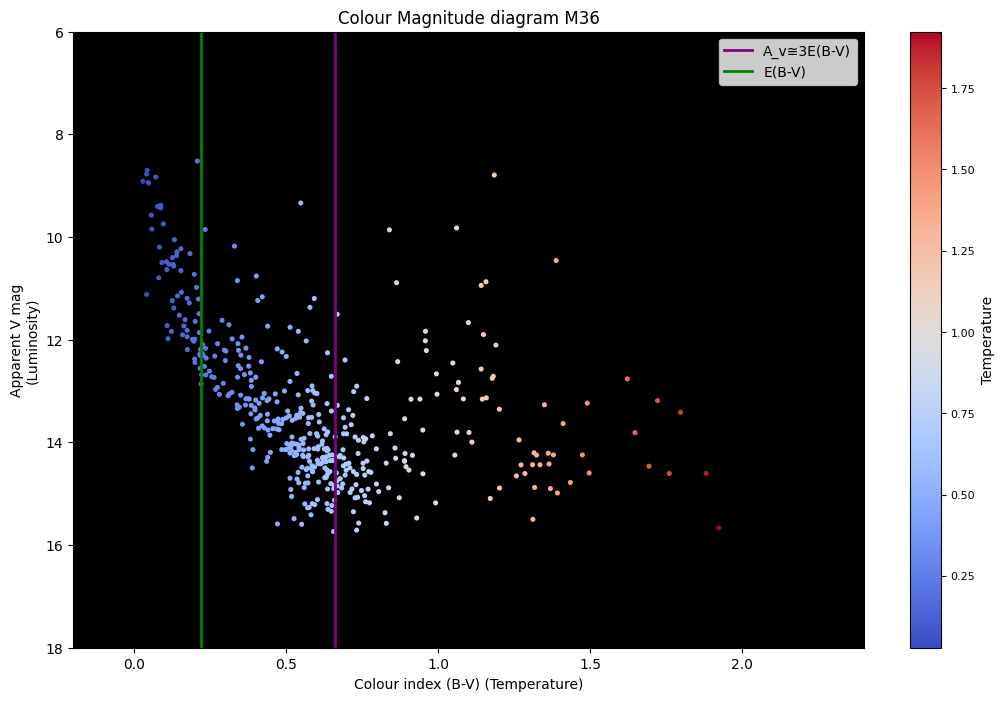

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colorbar import Colorbar

# Plot the CMD
plt.scatter(ClusterData["B_V"], ClusterData["Vmag"], c=ClusterData["B_V"], cmap="coolwarm", s=7)  # Increase marker size to 7

# Set y axis limits to show data below 8 for apparent V magnitude
plt.ylim((18, 6))  # Invert y-axis to match convention

# Set x axis limits to show a wider range of B-V color index values
plt.xlim((-0.2, 2.4))  # Adjust as needed

# Define the x-coordinates for the vertical lines
x_line_A_v = A_v
x_line_E_BV = E_BV

# Plot the vertical lines with different colors and labels
plt.axvline(x=x_line_A_v, color='purple', linestyle='-', linewidth=2, label='A_v≅3E(B-V)')  # Adjust linewidth as desired
plt.axvline(x=x_line_E_BV, color='green', linestyle='-', linewidth=2, label='E(B-V)')  # Adjust linewidth as desired

# Set plot title, labels
plt.title('Colour Magnitude diagram M36')
plt.xlabel('Colour index (B-V) (Temperature)')  # Add temperature text to label
plt.ylabel('Apparent V mag\n(Luminosity)')  # Added an extra label

# Create a colorbar on the right side
cbar = plt.colorbar(fraction=0.1, orientation='vertical', label='Temperature', aspect=20)  # Adjust aspect ratio
cbar.ax.tick_params(labelsize=8)  # Adjust tick label size

# Create a legend in the upper right corner
legend = plt.legend(loc='upper right', fontsize=10)  # Adjust legend location and fontsize

# Change the background color to black
fig = plt.gcf()
ax = plt.gca()
ax.set_facecolor('black')

plt.show()